# Multi Agents - 고객 지원 챗봇 (초급)

## 개요
LangGraph를 활용하여 여러 에이전트가 협력하는 고객 지원 챗봇을 구현합니다.

## 구성
1. **분류 에이전트**: 고객 문의 유형을 판단 (기술/결제/일반)
2. **기술 지원 에이전트**: 기술 문제 해결
3. **결제 지원 에이전트**: 결제 관련 처리
4. **일반 상담 에이전트**: 일반 문의 응답

## 학습 목표
- 조건부 라우팅 (conditional routing)
- 상태 관리 (state management)
- 여러 에이전트 중 선택적 실행


## 1. 환경 설정 및 라이브러리 임포트


In [1]:
import os
from typing import TypedDict, Literal, Annotated
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage


### API 키 설정
- [OpenAI API 키](https://platform.openai.com/api-keys)

In [ ]:
import os

# API 키 설정
os.environ["OPENAI_API_KEY"] = "sk-proj-"

# API 키 확인
openai_key = os.getenv("OPENAI_API_KEY")

if openai_key:
    print("OpenAI API 키가 설정되었습니다. (GPT 모델 사용)")
else:
    print("OpenAI API 키가 없습니다.")

OpenAI API 키가 설정되었습니다. (GPT 모델 사용)


### LLM 초기화

In [3]:
# LLM 초기화
llm = ChatOpenAI(model="gpt-5-nano")

## 2. 상태 정의 (State Management)

그래프에서 사용할 상태 구조를 정의합니다. 상태는 모든 노드 간에 공유되며, 각 에이전트가 정보를 추가하거나 수정할 수 있습니다.


In [4]:
class SupportState(TypedDict):
    """
    고객 지원 챗봇의 상태를 정의하는 클래스
    
    Attributes:
        question: 고객의 원본 문의 내용
        category: 문의 유형 ("technical", "billing", "general")
        response: 최종 응답 메시지
    """
    question: str
    category: str
    response: str

print("상태 구조가 정의되었습니다.")


상태 구조가 정의되었습니다.


## 3. 에이전트 노드 정의

각 에이전트의 역할과 기능을 정의합니다.


### 3.1 분류 에이전트 (Classifier Agent)

고객의 문의 내용을 분석하여 적절한 지원 유형으로 분류합니다.


In [5]:
def classifier_agent(state: SupportState) -> SupportState:
    """
    고객 문의를 분석하여 적절한 카테고리로 분류하는 에이전트
    
    Returns:
        - "technical": 기술 지원이 필요한 경우
        - "billing": 결제 관련 문의인 경우
        - "general": 일반적인 문의인 경우
    """
    question = state["question"]
    
    # LLM을 사용하여 문의 유형 분류
    messages = [
        SystemMessage(content="""
            당신은 고객 문의를 분류하는 전문가입니다.
            고객의 문의를 다음 세 가지 카테고리 중 하나로 분류하세요:

            1. technical - 기술적 문제, 오류, 버그, 기능 작동 문제 등
            2. billing - 결제, 환불, 요금제, 구독 관련 문제
            3. general - 일반 문의, 제품 정보, 사용 방법 등

            반드시 'technical', 'billing', 'general' 중 하나의 단어만 응답하세요."""),
        HumanMessage(content=f"다음 문의를 분류하세요: {question}")
    ]
    
    response = llm.invoke(messages)
    category = response.content.strip().lower()
    
    print(f"[분류 에이전트] 문의 유형: {category}")
    
    return {
        "question": question,
        "category": category,
        "response": ""
    }


In [6]:
# 테스트
test_state = {"question": "로그인이 안됩니다", "category": "", "response": ""}
result = classifier_agent(test_state)
print(f"분류 결과: {result['category']}")

Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


[분류 에이전트] 문의 유형: technical
분류 결과: technical


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTP

### 3.2 기술 지원 에이전트

기술적인 문제를 해결하는 전문 에이전트입니다.


In [7]:
def technical_support_agent(state: SupportState) -> SupportState:
    """
    기술적 문제를 해결하는 에이전트
    """
    question = state["question"]
    
    messages = [
        SystemMessage(content="""
            당신은 기술 지원 전문가입니다.
            고객의 기술적 문제를 친절하고 명확하게 해결해주세요.
            단계별 해결 방법을 제시하고, 가능한 원인을 설명하세요."""),
        HumanMessage(content=question)
    ]
    
    response = llm.invoke(messages)
    answer = response.content
    
    print(f"[기술 지원 에이전트] 응답 생성 완료")
    
    return {
        "question": question,
        "category": state["category"],
        "response": answer
    }


### 3.3 결제 지원 에이전트

결제 및 청구 관련 문제를 처리하는 에이전트입니다.


In [8]:
def billing_support_agent(state: SupportState) -> SupportState:
    """
    결제 및 청구 관련 문제를 처리하는 에이전트
    """
    question = state["question"]
    
    messages = [
        SystemMessage(content="""
            당신은 결제 및 청구 관련 전문 상담원입니다.
            고객의 결제, 환불, 요금제 관련 문의에 정확하고 친절하게 답변하세요.
            필요한 경우 정책과 절차를 안내하세요."""),
        HumanMessage(content=question)
    ]
    
    response = llm.invoke(messages)
    answer = response.content
    
    print(f"[결제 지원 에이전트] 응답 생성 완료")
    
    return {
        "question": question,
        "category": state["category"],
        "response": answer
    }


### 3.4 일반 상담 에이전트

일반적인 문의사항을 처리하는 에이전트입니다.


In [9]:
def general_support_agent(state: SupportState) -> SupportState:
    """
    일반적인 문의사항을 처리하는 에이전트
    """
    question = state["question"]
    
    messages = [
        SystemMessage(content="""
            당신은 친절한 고객 상담원입니다.
            고객의 일반적인 문의에 친절하고 유용한 정보를 제공하세요.
            제품이나 서비스에 대한 설명을 명확하게 전달하세요."""),
        HumanMessage(content=question)
    ]
    
    response = llm.invoke(messages)
    answer = response.content
    
    print(f"[일반 상담 에이전트] 응답 생성 완료")
    
    return {
        "question": question,
        "category": state["category"],
        "response": answer
    }


## 4. 조건부 라우팅 (Conditional Routing)

분류 결과에 따라 적절한 에이전트로 라우팅하는 함수를 정의합니다.


In [10]:
def route_question(state: SupportState) -> Literal["technical", "billing", "general"]:
    """
    분류된 카테고리에 따라 적절한 에이전트로 라우팅하는 함수
    """
    category = state["category"]
    
    print(f"[라우터] '{category}' 카테고리로 라우팅")
    
    # 카테고리에 따라 다음 노드 결정
    if category == "technical":
        return "technical"
    elif category == "billing":
        return "billing"
    else:
        return "general"

print("라우팅 함수가 정의되었습니다.")


라우팅 함수가 정의되었습니다.


## 5. 그래프 구성

LangGraph를 사용하여 전체 워크플로우를 구성합니다.

In [11]:
# StateGraph 생성
workflow = StateGraph(SupportState)

# 노드 추가
workflow.add_node("classifier", classifier_agent)
workflow.add_node("technical", technical_support_agent)
workflow.add_node("billing", billing_support_agent)
workflow.add_node("general", general_support_agent)

# 시작점 설정
workflow.set_entry_point("classifier")

# 조건부 엣지 추가 (분류 에이전트 -> 라우팅)
workflow.add_conditional_edges(
    "classifier",  # 출발 노드
    route_question,  # 라우팅 함수
    {
        "technical": "technical",  # 기술 지원으로
        "billing": "billing",      # 결제 지원으로
        "general": "general"       # 일반 상담으로
    }
)

# 각 전문 에이전트에서 END로 연결
workflow.add_edge("technical", END)
workflow.add_edge("billing", END)
workflow.add_edge("general", END)

# 그래프 컴파일
app = workflow.compile()

print("그래프가 성공적으로 구성되었습니다!")


그래프가 성공적으로 구성되었습니다!


## 6. 그래프 시각화 (선택사항)

그래프의 구조를 시각적으로 확인할 수 있습니다.


```
시작
  |
  v
분류 에이전트
  |
  v
조건부 라우팅
  |
  +-- technical --> 기술 지원 에이전트 --> 종료
  |
  +-- billing --> 결제 지원 에이전트 --> 종료
  |
  +-- general --> 일반 상담 에이전트 --> 종료
```


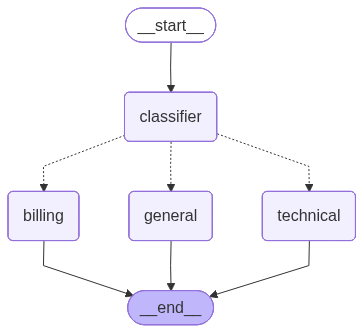

In [12]:
try:
    from IPython.display import Image, display
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"그래프 시각화를 위해서는 graphviz가 필요합니다: {e}")
    print("텍스트로 그래프 구조를 확인하세요:")
    print(app.get_graph())


## 7. 테스트 예제

다양한 문의 유형으로 챗봇을 테스트해봅니다.


### 7.1 테스트 케이스 1: 기술 지원 문의


In [13]:
print("=" * 60)
print("테스트 1: 기술 지원 문의")
print("=" * 60)

question1 = "앱이 자꾸 강제 종료됩니다. 어떻게 해야 하나요?"

# 초기 상태 생성
initial_state = {
    "question": question1,
    "category": "",
    "response": ""
}

# 그래프 실행
result = app.invoke(initial_state)

print(f"\n질문: {result['question']}")
print(f"분류: {result['category']}")
print(f"\n응답:\n{result['response']}")
print("=" * 60)


테스트 1: 기술 지원 문의
[분류 에이전트] 문의 유형: technical
[라우터] 'technical' 카테고리로 라우팅
[기술 지원 에이전트] 응답 생성 완료

질문: 앱이 자꾸 강제 종료됩니다. 어떻게 해야 하나요?
분류: technical

응답:
앱이 자꾸 강제 종료되는 문제, 차근차근 해결해볼게요. 아래 순서대로 시도해 보시고, 각 단계 후에 문제가 해결되었는지 알려주세요.

먼저 준비할 정보(가능하면 알려주시면 더 정확히 도와드릴 수 있습니다)
- 어떤 기기(OS 및 모델): 예) Android 13/ Galaxy S23, iPhone iOS 17 등
- 문제의 앱 이름과 버전
- 강제 종료가 언제 발생하나요? 시작/이용 중/특정 화면에서만 등
- 네트워크 연결 여부(와이파이/모바일 데이터)나 VPN 사용 여부
- 최근에 앱이나 OS 업데이트가 있었나요?

1) 기기 재시작
- 간단하지만 효과가 큰 경우가 많습니다. 기기를 완전히 재시작해 보세요.

2) 앱 재시작 및 강제 종료 재현 여부 확인
- 앱을 완전히 종료하고(필요하면 메모리에서 강제 종료) 다시 열어 동일한 상황에서 재현되는지 확인합니다.

3) 업데이트 확인
- 앱: 앱 스토어/플레이스토어에서 최신 버전으로 업데이트.
- OS: 기기의 운영체제도 최신 상태인지 확인하고 필요하면 업데이트.

4) 저장 공간 및 메모리 확인
- 기기에 충분한 저장공간이 있는지 확인(여유 공간 부족은 앱 강제 종료를 유발할 수 있음).
- 백그라운드에서 많은 앱이 동작 중인지 확인하고 필요없는 앱 종료.

Android일 때 추가 팁
- 앱별 저장 데이터 초기화
  Settings > Apps > [앱 이름] > Storage > Clear Cache(캐시 삭제), Clear Data(데이터 초기화) — 주의: 로그인 정보가 제거될 수 있습니다.
- 강제 종료 방지 설정 확인
  Settings > Battery > Battery optimization(배터리 최적화) > [앱 이름] 제외(또는 최적화

### 7.2 테스트 케이스 2: 결제 지원 문의


In [14]:
print("=" * 60)
print("테스트 2: 결제 지원 문의")
print("=" * 60)

question2 = "구독을 취소하고 환불받고 싶습니다."

initial_state = {
    "question": question2,
    "category": "",
    "response": ""
}

result = app.invoke(initial_state)

print(f"\n질문: {result['question']}")
print(f"분류: {result['category']}")
print(f"\n응답:\n{result['response']}")
print("=" * 60)


테스트 2: 결제 지원 문의
[분류 에이전트] 문의 유형: billing
[라우터] 'billing' 카테고리로 라우팅
[결제 지원 에이전트] 응답 생성 완료

질문: 구독을 취소하고 환불받고 싶습니다.
분류: billing

응답:
도와드리겠습니다. 구독 취소와 환불은 이용하신 결제 경로에 따라 처리 방식이 다릅니다. 먼저 몇 가지 확인과 필요한 정보만 알려주시면 신속하게 안내드리겠습니다.

필요한 정보
- 가입 계정의 이메일 또는 사용자 ID
- 구독 이름/플랜(예: 기본/프리미엄 등)과 last 결제일
- 결제 수단(예: 카드의 끝 4자리)과 결제 플랫폼(당사 웹/Apple App Store/Google Play 등)
- 주문 번호가 있다면 함께 알려주시면 더 빠르게 진행됩니다
- 환불 요청 사유(선택적)

구독 취소 방법(플랫폼별 안내)
- 당사 웹/앱에서 직접 결제한 경우
  - 계정 메뉴로 이동 → 구독 관리 → 자동 갱신 해지
  - 즉시 해지되며 남은 기간 동안은 서비스 이용 여부가 정책에 따라 달라질 수 있습니다. 환불 가능 여부는 결제일, 사용 기간 등에 따라 다릅니다.
- Apple App Store에서 결제한 경우
  - Apple에 환불 요청이 필요합니다. 방법: 설정 > [본인 이름] > iTunes 및 App Store > Apple ID > 구독에서 해당 구독 취소, 필요 시 Apple의 환불 요청 절차 페이지를 이용
- Google Play에서 결제한 경우
  - Google Play 스토어에서 환불 요청이 필요합니다. 방법: Google Play 스토어 > 주문 내역 > 환불 요청 또는 문제 제기

다음 단계 제안
- 원하시면 제가 먼저 구독 취소 여부와 환불 가능성에 대해 확인해 보고, 필요 시 고객센터로 환불 심사를 요청해 드리겠습니다. 정보를 주시면 바로 처리 방향을 안내해 드리겠습니다.
- 플랫폼별로 다른 정책이 적용되므로, 가능하면 주문 번호나 결제 플랫폼 정보를 함께 알려주시면 정확히 안내해 드립니다.

질문에 답해 

### 7.3 테스트 케이스 3: 일반 상담 문의


In [15]:
print("=" * 60)
print("테스트 3: 일반 상담 문의")
print("=" * 60)

question3 = "프리미엄 플랜에는 어떤 기능들이 포함되나요?"

initial_state = {
    "question": question3,
    "category": "",
    "response": ""
}

result = app.invoke(initial_state)

print(f"\n질문: {result['question']}")
print(f"분류: {result['category']}")
print(f"\n응답:\n{result['response']}")
print("=" * 60)


테스트 3: 일반 상담 문의
[분류 에이전트] 문의 유형: general
[라우터] 'general' 카테고리로 라우팅
[일반 상담 에이전트] 응답 생성 완료

질문: 프리미엄 플랜에는 어떤 기능들이 포함되나요?
분류: general

응답:
좋습니다! 프리미엄 플랜에 포함된 일반적인 혜택은 서비스마다 조금씩 다르지만, 보통 아래와 같은 기능들이 제공됩니다.

일반적으로 프리미엄 플랜에 포함된 기능(서비스에 따라 다를 수 있음)
- 더 높은 사용 한도: 저장 공간, 요청/쿼리 수, 데이터 처리 용량 증가
- 광고 제거: 앱이나 웹에서 광고가 표시되지 않음
- 우선 지원: 빠른 응답 시간의 고객 지원(24/7 또는 우선 접속)
- 다중 기기 동기화 및 오프라인 사용: 여러 디바이스에서 데이터 동기화, 오프라인 기능
- 고급 분석/리포트: 상세 대시보드, 맞춤형 보고서, 데이터 시각화
- API 접근 및 개발 도구: API 사용 권한, 웹후크, 개발자 도구
- 고급 보안 기능: 이중 인증, SSO, 데이터 암호화 등
- 팀 관리 기능: 역할 기반 접근 제어, 사용자 관리, 공동 작업 도구
- 백업/복구 옵션: 자동 백업, 롤백 가능성
- 커스터마이징: UI 테마, 워크플로우, 알림 설정 등의 고급 커스터마이징
- 가격/결제 옵션: 연간 결제 할인, 번들 패키지 할인 등

다만 실제 혜택은 서비스마다 조금씩 다릅니다. 정확한 목록을 원하시면 아래 중 하나를 알려주세요.
- 어떤 서비스의 프리미엄 플랜을 문의하시는지(서비스명 또는 제품명)
- 또는 해당 플랜의 가격 페이지 링크를 공유해 주시기

확인해 드리겠습니다. 또한 원하시면 제가 해당 서비스의 실제 혜택을 요약해 드리겠습니다.
